In [3]:
import tensorflow as tf
import time
def curTime():
    return round(time.time() * 1000)
print(28500 % 150)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

0


In [4]:
# Extracting datasets to input matrix
import numpy as np
import pandas as pd
from tqdm import tqdm
import random



dataset_size = 28000
pred_dataset_size = 8900

flow_size = 50
number_flows = int(dataset_size/flow_size) -2 #substract 2 so first two flows are ignored
pred_number_flows = int(pred_dataset_size/flow_size) - 2
seed=2
val=0
# paths
watermarked_flows = pd.read_csv('caps/detector/TirP2pTrainBuf50Icbw120.csv', usecols=['Time']) # 28787
regular_flows = pd.read_csv('caps/detector/TirP2pTrainBuf50None.csv', usecols=['Time']) # 45000
watermarked_flows_prediction = pd.read_csv('caps/detector/TirP2pTestBuf50Icbw120V2.csv', usecols=['Time']) # 10109
regular_flows_prediction = pd.read_csv('caps/detector/TirP2pTrainBuf50None.csv', usecols=['Time']) # 8981



features = np.zeros((number_flows*2, 1, flow_size, 1))
classes = np.zeros(features.shape[0])
indexes = np.arange(features.shape[0])

# random.Random(seed).shuffle(indexes) # Consistent randomization
random.Random(3).shuffle(indexes) # Inconsistent randomization

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True)
for train_indexes,valid_indexes in skf.split(features, classes):
    break
    
print((train_indexes.shape, valid_indexes.shape))    
    
#print((features[train_indexes[]].shape[0], features[valid_indexes].shape[0]))

def outlier(delay):
    return delay if delay < 5000 else 100

    

#for i in range(flow_size):
#    if i == 0:
#        features[0,0,i] = (watermarked_flows['Time'])[i]
#        features[1,0,i] = (regular_flows['Time'])[i]
#    else:
#        features[0,0,i]=outlier((watermarked_flows['Time'][i]-watermarked_flows['Time'][i-1])*1000)
#        features[1,0,i]=outlier((regular_flows['Time'][i]-regular_flows['Time'][i-1])*1000)
#
#classes[0]=1
#classes[1]=0
    
watermarked_index = flow_size;
regular_index = flow_size;
for flow_index in tqdm(range(0, number_flows*2)):      #changed range to start from 0 so first two flows are ignored
    if flow_index%2==0:
        classes[flow_index]=1
        for i in range(flow_size):  
            features[flow_index,0,i]=outlier((watermarked_flows['Time'][watermarked_index]-watermarked_flows['Time'][watermarked_index-1])*1000)
            watermarked_index+=1
    else:
        classes[flow_index]=0
        for i in range(flow_size):
            features[flow_index,0,i]=outlier((regular_flows['Time'][regular_index]-regular_flows['Time'][regular_index-1])*1000)
            regular_index+=1
    

print(features.shape)

((837,), (279,))


100%|██████████| 1116/1116 [00:00<00:00, 2048.69it/s]

(1116, 1, 50, 1)


In [5]:
#         ================================================================================================
#         ======================================== Model of the CNN ======================================
#         ================================================================================================


import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Layer, Dense, Conv2D, MaxPool2D, Dropout, Flatten,
                                     GlobalAveragePooling2D, ZeroPadding2D)


kernel_size = ([1, 5], [1, 5])
filters = (500, 100)

model = Sequential()
model.add(Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=(1,1), activation='relu'))
model.add(MaxPool2D([1,5]))
model.add(Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=(1,1), activation='relu'))
model.add(MaxPool2D([1,5]))
model.add(Flatten())

model.add(Dense(units=3000, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=800, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [6]:
#         ================================================================================================
#         ======================================== Training ==============================================
#         ================================================================================================


from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001
batch_size=256
epochs=150
loss = 'binary_crossentropy'
callback = EarlyStopping(monitor='val_loss', patience = 50)

optimizer=Adam(learning_rate=learning_rate)
model.compile(optimizer = optimizer, loss=loss, metrics=['binary_accuracy'])
timestamp1 = curTime()
# history = model.fit(features[train_indexes[val:]], classes[train_indexes[val:]], validation_data=(features[valid_indexes],classes[valid_indexes]), batch_size=batch_size, epochs=epochs, callbacks=[callback])
history = model.fit(features[train_indexes[val:]], classes[train_indexes[val:]], validation_data=(features[valid_indexes],classes[valid_indexes]), batch_size=batch_size, epochs=epochs, callbacks=[callback])

Epoch 1/150
4/4 [==============================] - 2s 90ms/step - loss: 3.8568 - binary_accuracy: 0.5197 - val_loss: 1.5239 - val_binary_accuracy: 0.4982
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 1.7883 - binary_accuracy: 0.5842 - val_loss: 0.3174 - val_binary_accuracy: 0.8817
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 1.1644 - binary_accuracy: 0.6655 - val_loss: 0.4968 - val_binary_accuracy: 0.7491
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 0.8575 - binary_accuracy: 0.7204 - val_loss: 0.3349 - val_binary_accuracy: 0.8602
Epoch 5/150
4/4 [==============================] - 0s 16ms/step - loss: 0.7524 - binary_accuracy: 0.7814 - val_loss: 0.2851 - val_binary_accuracy: 0.8889
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 0.6597 - binary_accuracy: 0.8220 - val_loss: 0.2952 - val_binary_accuracy: 0.8817
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 0.44

Epoch 54/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1243 - binary_accuracy: 0.9618 - val_loss: 0.2839 - val_binary_accuracy: 0.9391
Epoch 55/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1110 - binary_accuracy: 0.9642 - val_loss: 0.2945 - val_binary_accuracy: 0.9391
Epoch 56/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0932 - binary_accuracy: 0.9713 - val_loss: 0.3054 - val_binary_accuracy: 0.9534
Epoch 57/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0852 - binary_accuracy: 0.9701 - val_loss: 0.3283 - val_binary_accuracy: 0.9211
Epoch 58/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0963 - binary_accuracy: 0.9665 - val_loss: 0.3319 - val_binary_accuracy: 0.9427
Epoch 59/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0939 - binary_accuracy: 0.9701 - val_loss: 0.3320 - val_binary_accuracy: 0.9247
Epoch 60/150
4/4 [==============================] - 0s 15ms/step - los

In [7]:
#         ================================================================================================
#         ======================================== Testing ==============================================
#         ================================================================================================

timestamp2 = curTime()

features_prediction = np.zeros((pred_number_flows*2, 1, flow_size, 1))
classes_prediction = np.zeros(features_prediction.shape[0])

pred_watermarked_index = flow_size;
pred_regular_index = flow_size + 28000;
for flow_index in tqdm(range(0, pred_number_flows*2)):      #changed range to start from 0 so first two flows are ignored
    if flow_index%2==0:
        classes_prediction[flow_index]=1
        for i in range(flow_size):  
            features_prediction[flow_index,0,i]=outlier((watermarked_flows_prediction['Time'][pred_watermarked_index]-watermarked_flows_prediction['Time'][pred_watermarked_index-1])*1000)
            pred_watermarked_index+=1
    else:
        classes_prediction[flow_index]=0
        for i in range(flow_size):
            features_prediction[flow_index,0,i]=outlier((regular_flows_prediction['Time'][pred_regular_index]-regular_flows_prediction['Time'][pred_regular_index-1])*1000)
            pred_regular_index+=1


fp=0; fn=0; tp=0; tn=0
pred_classes = classes_prediction
timestamp3 = curTime()
pred = model.predict(features_prediction)
timestamp4 = curTime()
print(('TEST',classes[train_indexes].shape[0]-val, classes[valid_indexes].shape, pred_classes.shape))

#print(pred_classes)
#print(np.around(pred.flatten(),3))
for i in range(pred.shape[0]):
    if pred_classes[i]==0:
        if pred[i]>0.5: fp+=1
        else: tn+=1
    else:
        if pred[i]>0.5: tp+=1
        else: fn+=1            

# Sensitivity, hit rate, recall, or true positive rate
tpr = tp/(tp+fn)
# Fall out or false positive rate
fpr = fp/(fp+tn)
metrics = [fpr, tpr, (tp+tn)/(tn+tp+fp+fn)]
print("FPS|TPR|BINARY-ACC")
print(np.around(metrics, 4))





100%|██████████| 352/352 [00:00<00:00, 2005.29it/s]


('TEST', 837, (279,), (352,))
FPS|TPR|BINARY-ACC
[0.3011 0.9716 0.8352]


In [8]:
print(('TEST',kernel_size,classes[train_indexes].shape[0]-val, classes[valid_indexes].shape, pred_classes.shape))
results = np.around(metrics,4)
listToStr = ' '.join([str(elem) for elem in results])
print(listToStr.replace(".",","))
fp=0; fn=0; tp=0; tn=0    
if(True):
    pred_classes = classes[valid_indexes]
    pred = model.predict(features[valid_indexes])
else:
    pred_classes = classes[train_indexes]
    pred = model.predict(features[train_indexes])
#print(pred_classes)
#print(np.around(pred.flatten(),3))
for i in range(pred.shape[0]):
    if pred_classes[i]==0:
        if pred[i]>0.5: fp+=1
        else: tn+=1
    else:
        if pred[i]>0.5: tp+=1
        else: fn+=1            
# Sensitivity, hit rate, recall, or true positive rate
tpr = tp/(tp+fn)
# Fall out or false positive rate
fpr = fp/(fp+tn)
metrics = [fpr, tpr, (tp+tn)/(tn+tp+fp+fn)]
print("\nVal - FPS|TPR|BINARY-ACC")
results = np.around(metrics,4)
listToStr = ' '.join([str(elem) for elem in results])
print(listToStr.replace(".",","))

print((timestamp2-timestamp1,timestamp4-timestamp3))

('TEST', ([1, 5], [1, 5]), 837, (279,), (352,))
0,3011 0,9716 0,8352

Val - FPS|TPR|BINARY-ACC
0,1357 0,9856 0,9247
(5820, 119)


In [9]:
if val!=0:
    fp=0; fn=0; tp=0; tn=0
    pred_classes = classes[train_indexes[:val]]
    pred = model.predict(features[train_indexes[:val]])
    print((kernel_size, classes[train_indexes[:-val]].shape, classes[valid_indexes].shape, pred_classes.shape))
    #print(pred_classes)
    #print(np.around(pred.flatten(),3))
    for i in range(pred.shape[0]):
        if pred_classes[i]==0:
            if pred[i]>0.5: fp+=1
            else: tn+=1
        else:
            if pred[i]>0.5: tp+=1
            else: fn+=1            

    # Sensitivity, hit rate, recall, or true positive rate
    tpr = tp/(tp+fn)
    # Fall out or false positive rate
    fpr = fp/(fp+tn)
    metrics = [fpr, tpr, (tp+tn)/(tn+tp+fp+fn)]
    print("FPS|TPR|BINARY-ACC")
    results = np.around(metrics, 4) 
    listToStr = ' '.join([str(elem) for elem in results])
    print(listToStr.replace(".",","))
    
    

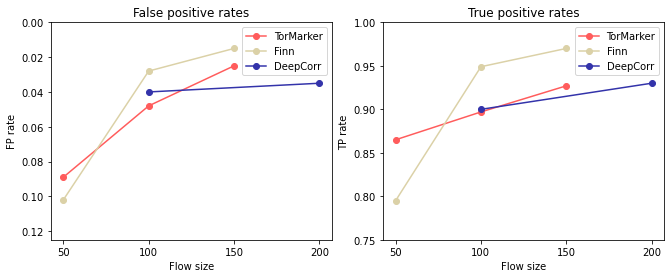

In [11]:


import matplotlib.pyplot as plt


plt.figure(0, figsize=(11, 4))
plt.subplots_adjust(wspace=0.18, hspace=0.1)

plt.subplot(1, 2, 1)
# plt.gca().invert_yaxis()
# plt.plot([50, 100, 150], [0.484, 0.457, 0.423], '-o', color='#4dccce', label='ICBW amp=40')
# plt.plot([50, 100, 150], [0.455, 0.451, 0.388], '-o', color='#4dcc4a', label='ICBW amp=80')
# plt.plot([50, 100, 150], [0.064, 0.046, 0.044], '-o', color='#ff5c5c', label='ICBW Skype') # Skype
# plt.plot([50, 100, 150], [0.213, 0.187, 0.143], '-o', color='#d4c6ba', label='Rainbow Skype') # Skype
# plt.plot([50, 100, 150], [0.254, 0.236, 0.222], '-o', color='#ff9300', label='Rainbow amp=40')

# plt.plot([50, 100, 150], [0.301, 0.256, 0.222], '--o', color='#a30707', label='ICBW P2P') # P2P
plt.plot([50, 100, 150], [0.089, 0.048, 0.025], '-o', color='#ff5c5c', label='TorMarker') # P2P
plt.plot([50, 100, 150], [0.102, 0.028, 0.015], '-o', color='#dbd1a7', label='Finn') # P2P
plt.plot([100, 200], [0.04, 0.035], '-o', color='#3333aa', label='DeepCorr') # P2P

# plt.plot([1, 2, 3, 4], [0, 2, 3, 4], '-o', color='#a30707', label='False Positives')

plt.xticks([50, 100, 150, 200])
#plt.yticks([0.13, 0.111, 0.097, 0.089, 0.074, 0.026])
plt.ylim(0.125 , 0.0)
plt.ylabel('FP rate')
plt.xlabel('Flow size')
plt.legend()
plt.title('False positive rates')

plt.subplot(1, 2, 2)
# # plt.plot([50, 100, 150], [0.707, 0.714, 0.725], '-o', color='#4dccce', label='ICBW amp=40')
# # plt.plot([50, 100, 150], [0.719, 0.738, 0.744], '-o', color='#4dcc4a', label='ICBW amp=80')
# plt.plot([50, 100, 150], [0.795, 0.829, 0.854], '-o', color='#ff5c5c', label='ICBW Skype') # Skype
# plt.plot([50, 100, 150], [0.845, 0.867, 0.898], '-o', color='#d4c6ba', label='Rainbow Skype') # Skype
# # plt.plot([50, 100, 150], [0.840, 0.844, 0.861], '-o', color='#ff9300', label='Rainbow amp=40')

# plt.plot([50, 100, 150], [0.798, 0.823, 0.843], '--o', color='#a30707', label='ICBW P2P') # P2P
# plt.plot([50, 100, 150], [0.827, 0.862, 0.887], '--o', color='#b09c8c', label='Rainbow P2P') # P2P
# # plt.plot([50, 100, 150], [0.845, 0.867, 0.898], '--o', color='#ff9300', label='Rainbow amp=40')

plt.plot([50, 100, 150], [.865, .897, .927], '-o', color='#ff5c5c', label='TorMarker') # P2P
plt.plot([50, 100, 150], [.795, .949, .97], '-o', color='#dbd1a7', label='Finn') # P2P
plt.plot([100, 200], [.90, .93], '-o', color='#3333aa', label='DeepCorr') # P2P

# plt.plot([1, 2, 3, 4], [94/94, 47/54, 32/42, 23/34], '-o', color='#4dcc4a', label='True Positives') # skype
# plt.plot([1, 2, 3, 4], [0, 7, 10, 11], '-o', color='#a30707', label='False Positives')

plt.xticks([50, 100, 150, 200])
# plt.yticks([0, 7, 10, 11, 94, 47, 32, 23])
plt.ylim(0.75 , 1.0)
plt.ylabel('TP rate')
plt.xlabel('Flow size')
plt.legend()
# plt.xticks([50, 100, 150])
# plt.ylim(0.6, 1.0)
# plt.ylabel('Rate')
# plt.xlabel('Flow size')
# plt.legend()
plt.title('True positive rates')
plt.show()
